In [ ]:
import cv2
from ipywidgets import *
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import scipy.stats as stats
from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny
from skimage import data, io, img_as_ubyte, transform
from skimage.color import rgb2gray, rgba2rgb

In [ ]:
def bin_img(url):
    img = io.imread(url)
    if img.shape[2] == 4:
        img = rgba2rgb(img)
    img = 1-rgb2gray(img)
    return img > 0

def plot_moments(moment="m00", centroid=False):  
    plt.figure(figsize=(10,10))
    for i, im in enumerate(figs):
        img = img_as_ubyte(im)
        contours, _ = cv2.findContours(img,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
        moments = cv2.moments(contours[0])
        if centroid:
            cX = int(moments["m10"] / moments["m00"])
            cY = int(moments["m01"] / moments["m00"])
            cv2.circle(img, (cX, cY), 10, (0, 0, 0), -1)
        plt.subplot(2,2,i+1);
        plt.title(moment+ ": "+str(moments[moment]))
        plt.imshow(img, cmap='gray')

def heatmap(data, labels, ax, colormap="Wistia", c="b", title=""):   
    im = ax.imshow(data, cmap=colormap)
    n = len(labels)
    ax.set_xticks(np.arange(n))
    ax.set_yticks(np.arange(n))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)

    for i in range(n):
        for j in range(n):
            text = ax.text(j, i, data[i, j], ha="center", va="center", color=c, size='x-large')
        
    if title != "":
        ax.set_title(title)

def hu_dist():
    contours = [contour for contour, h in [cv2.findContours(img_as_ubyte(img),cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE) for img in figs]]
    n = len(contours)
    dists = np.zeros((n,n))

    for i in range(n):
        for j in range(n):
            dists[i][j] = round(cv2.matchShapes(contours[i][0],contours[j][0],cv2.CONTOURS_MATCH_I2,0),3)

    fig, ax = plt.subplots(figsize=(6,6))
    heatmap(dists, ["star", "star_t", "star_sr", "heart"], ax)
            
def confusion_matrix(thresh = 105):
    mu1 = 100
    mu2= 120
    sigma = 7
    xs = [np.linspace(m-3.5*sigma, m+3.5*sigma, 100) for m in [mu1, mu2]]
    fig, axs= plt.subplots(1, 2, figsize=(15,5))

    for x, m in zip(xs,[mu1, mu2]):
        y = stats.norm.pdf(x, m, sigma)
        axs[0].plot(x, y)
        axs[0].fill_between(x, y, alpha=0.5)
    axs[0].axvline(x=thresh, c='k')
    
    positive = np.random.normal(mu2, sigma, 50)
    negative = np.random.normal(mu1, sigma, 50)
    
    mat = np.zeros((2,2), dtype=np.long)
    mat[0,0] = sum(positive >= thresh)
    mat[0,1] = sum(negative >= thresh)
    mat[1,0] = sum(positive < thresh)
    mat[1,1] = sum(negative < thresh)
    accuracy = (mat[0,0] + mat[1,1])/np.sum(mat)
    
    heatmap(mat, ['positive', 'negative'], axs[1], colormap="YlGn", c="r", title="accuracy: "+str(accuracy))


img = bin_img("https://upload.wikimedia.org/wikipedia/commons/thumb/7/77/Full_star.svg/480px-Full_star.svg.png") 
img2 = bin_img("https://upload.wikimedia.org/wikipedia/commons/thumb/4/46/Love_Heart_symbol_inglow.svg/521px-Love_Heart_symbol_inglow.svg.png") 

padding = 200
star = np.pad(img, ((padding, padding), (padding, padding)), 'constant', constant_values=(0, 0))
star2 = np.pad(img, ((0, padding*2), (0, padding*2)), 'constant', constant_values=(0, 0))
star3 = np.pad(transform.rescale(transform.rotate(star,45), 0.5), ((0, padding*2), (0, padding*2)), 'constant', constant_values=(0, 0))
heart = np.pad(img2, ((padding, padding), (padding, padding)), 'constant', constant_values=(0, 0))

figs = [star, star2, star3, heart]

### Transformacja Hougha

In [ ]:
#https://scikit-image.org/docs/dev/auto_examples/edges/plot_line_hough_transform.html

# Constructing test image
image = np.zeros((200, 200))
idx = np.arange(25, 175)
image[idx[::-1], idx] = 255
image[idx, idx] = 255

image = io.imread("./projekt/images/sddf.jpg", as_gray=True)
# image = image > 0.9

# Classic straight-line Hough transform
# Set a precision of 0.5 degree.
tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360)
h, theta, d = hough_line(image, theta=tested_angles)

# Generating figure 1
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
ax = axes.ravel()

ax[0].imshow(image, cmap=cm.gray)
ax[0].set_title('Input image')
ax[0].set_axis_off()

ax[1].imshow(np.log(1 + h),
             extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]), d[-1], d[0]],
             cmap=cm.gray, aspect=1/1.5)
ax[1].set_title('Hough transform')
ax[1].set_xlabel('Angles (degrees)')
ax[1].set_ylabel('Distance (pixels)')
ax[1].axis('image')

ax[2].imshow(image, cmap=cm.gray)
origin = np.array((0, image.shape[1]))
for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
    ax[2].plot(origin, (y0, y1), '-r')
ax[2].set_xlim(origin)
ax[2].set_ylim((image.shape[0], 0))
ax[2].set_axis_off()
ax[2].set_title('Detected lines')

plt.tight_layout()
plt.show()

### Momenty

In [ ]:
plt.figure(figsize=(10,10))
for i, s in enumerate(figs):
    plt.subplot(2,2,i+1);
    plt.imshow(s, cmap='gray')    

#### Moment zwykły

$$M_{ij} = \sum_{x}\sum_{y}x^iy^jI(x,y)$$

$${\textrm{Centroid: }\displaystyle \{{\bar {x}},\ {\bar {y}}\}=\left\{{\frac {M_{10}}{M_{00}}},{\frac {M_{01}}{M_{00}}}\right\}}$$

In [ ]:
plot_moments("m11", centroid=True)

#### Moment centralny

$$\mu_{ij} = \sum_{x}\sum_{y}(x-\bar{x})^i(y-\bar{y})^jI(x,y)$$

In [ ]:
plot_moments("mu11")

#### Moment centralny znormalizowany

$$\eta_{ij} = \frac{\mu_{ij}}{\mu_{00}^{\left(1+\frac{i+j}{2}\right)}}\textrm{,}$$
gdzie $i + j \geq 2$

In [ ]:
plot_moments("nu11")

#### Momenty Hu

$I_{1}=\eta _{{20}}+\eta _{{02}}$

$I_{2}=(\eta _{{20}}-\eta _{{02}})^{2}+4\eta _{{11}}^{2}$

$I_{3}=(\eta _{{30}}-3\eta _{{12}})^{2}+(3\eta _{{21}}-\eta _{{03}})^{2}$

$I_{4}=(\eta _{{30}}+\eta _{{12}})^{2}+(\eta _{{21}}+\eta _{{03}})^{2}$

$I_{5}=(\eta _{{30}}-3\eta _{{12}})(\eta _{{30}}+\eta _{{12}})[(\eta _{{30}}+\eta _{{12}})^{2}-3(\eta _{{21}}+\eta _{{03}})^{2}]+(3\eta _{{21}}-\eta _{{03}})(\eta _{{21}}+\eta _{{03}})[3(\eta _{{30}}+\eta _{{12}})^{2}-(\eta _{{21}}+\eta _{{03}})^{2}]$

$I_{6}=(\eta _{{20}}-\eta _{{02}})[(\eta _{{30}}+\eta _{{12}})^{2}-(\eta _{{21}}+\eta _{{03}})^{2}]+4\eta _{{11}}(\eta _{{30}}+\eta _{{12}})(\eta _{{21}}+\eta _{{03}})$

$I_{7}=(3\eta _{{21}}-\eta _{{03}})(\eta _{{30}}+\eta _{{12}})[(\eta _{{30}}+\eta _{{12}})^{2}-3(\eta _{{21}}+\eta _{{03}})^{2}]-(\eta _{{30}}-3\eta _{{12}})(\eta _{{21}}+\eta _{{03}})[3(\eta _{{30}}+\eta _{{12}})^{2}-(\eta _{{21}}+\eta _{{03}})^{2}]$


In [ ]:
hu_dist()

### kNN

![knn](https://docs.opencv.org/master/knn_simple.png)

[https://docs.opencv.org/master/d5/d26/tutorial_py_knn_understanding.html](https://docs.opencv.org/master/d5/d26/tutorial_py_knn_understanding.html)

### Tradycyjny algorytm

![pipeline](https://www.learnopencv.com/wp-content/uploads/2016/11/image-classification-pipeline-1024x372.jpg)

[https://www.learnopencv.com/image-recognition-and-object-detection-part1](https://www.learnopencv.com/image-recognition-and-object-detection-part1/)

### Sieci neuronowe

![nn](https://cs231n.github.io/assets/nn1/neural_net.jpeg)

[https://cs231n.github.io/neural-networks-1/](https://cs231n.github.io/neural-networks-1/)

![convnet](https://cs231n.github.io/assets/cnn/convnet.jpeg)

[https://cs231n.github.io/convolutional-networks](https://cs231n.github.io/convolutional-networks/)

### Macierz pomyłek

<table>
<tbody><tr>
<td>
<table style="border:none; float:left; margin-top:0;">
<tbody><tr>
<th style="background:white; border:none;" colspan="2" rowspan="2">
</th>
<th colspan="2" style="background:none;">Klasa rzeczywista
</th></tr>
<tr>
<th>pozytywna
</th>
<th>negatywna
</th></tr>
<tr>
<th rowspan="2" style="height:6em;">Klasa<br />przewidziana
</th>
<th>pozytywna
</th>
<td>prawdziwie<br />pozytywna (TP)
</td>
<td>fałszywie<br />pozytywna (FP)
</td></tr>
<tr>
<th>negatywna
</th>
<td>fałszywie<br />negatywna (FN)
</td>
<td>prawdziwie<br />negatywna (TN)
</td></tr></tbody></table>
</td></tr></tbody></table>

In [ ]:
interact(confusion_matrix, thresh=(80,140,1))

In [ ]:
img = cv2.imread('./projekt/images/sddf.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

kernel_size = 5
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)
low_threshold = 20
high_threshold = 150
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

rho = 1  # distance resolution in pixels of the Hough grid
theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 15  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 50  # minimum number of pixels making up a line
max_line_gap = 20  # maximum gap in pixels between connectable line segments
line_image = np.copy(img) * 0  # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)

for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),5)
    
    # Draw the lines on the  image
lines_edges = cv2.addWeighted(img, 0.8, line_image, 1, 0)

io.imshow(lines_edges)

In [ ]:
def find_line(photo_square, angle):
    size = photo_square.shape[0]
    tangens = round(math.tan(math.radians(angle)), 2)
    max_val = 0
    for k in range(size):
        suma = 0
        for y in range(size):
            for x in range(size):
                if x != k:
                    if tangens == round((y - k) / (x - k), 2) and photo_square[y][x] == 0:
                        suma += 1
        if suma > max_val:
            max_val = suma
    return max_val



Gamestate:
|-|-|-
|-|-|-
|-|-|-


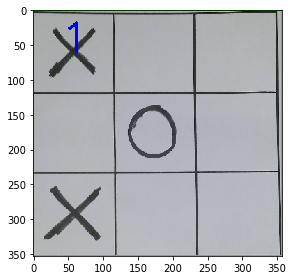

In [2]:
import numpy as np
import cv2
from skimage import io

#create a 2d array to hold the gamestate
gamestate = [["-","-","-"],["-","-","-"],["-","-","-"]]

#kernel used for noise removal
kernel =  np.ones((3, 3),np.uint8)
# Load a color image 
img = cv2.imread('./projekt/images/5.jpg')
# get the image width and height
img_width = img.shape[0]
img_height = img.shape[1]

# # Set minimum and max HSV values to display
# hMin = 0
# sMin = 0
# vMin = 30

# hMax = 179
# sMax = 255
# vMax = 255

# lower = np.array([hMin, sMin, vMin])
# upper = np.array([hMax, sMax, vMax])

# # Create HSV Image and threshold into a range.
# hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
# mask = cv2.inRange(hsv, lower, upper)
# output = cv2.bitwise_and(image,image, mask= mask)

# img = cv2.cvtColor(output, cv2.COLOR_BGR2GRAY)
# img = cv2.dilate(img, kernel, iterations=1)
# # img = cv2.erode(img, kernel, iterations=2)
# # img = cv2.Canny(img, 40, 120)
# img[img>35] = 255
# # io.imshow(image_canny)
# io.imshow(img)

# turn into grayscale
img_g =  cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# turn into thresholded binary
ret,thresh1 = cv2.threshold(img_g,0,255,cv2.THRESH_BINARY)
#remove noise from binary
thresh1 = cv2.morphologyEx(thresh1, cv2.MORPH_OPEN, kernel)

# img_g = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#find and draw contours. RETR_EXTERNAL retrieves only the extreme outer contours
contours, hierarchy = cv2.findContours(thresh1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(img, contours, -1, (0,255,0), 15)

# io.imshow(img)

tileCount = 0
for cnt in contours:
        # ignore small contours that are not tiles
        if cv2.contourArea(cnt) > 200000: 
                tileCount = tileCount+1
                # use boundingrect to get coordinates of tile
                x,y,w,h = cv2.boundingRect(cnt)
                # create new image from binary, for further analysis. Trim off the edge that has a line
                tile = thresh1[x+40:x+w-80,y+40:y+h-80]
                # create new image from main image, so we can draw the contours easily
                imgTile = img[x+40:x+w-80,y+40:y+h-80]

                #determine the array indexes of the tile
                tileX = round((x/img_width)*3)
                tileY = round((y/img_height)*3)     

                # find contours in the tile image. RETR_TREE retrieves all of the contours and reconstructs a full hierarchy of nested contours.
                c, hierarchy = cv2.findContours(tile, cv2.RETR_TREE , cv2.CHAIN_APPROX_SIMPLE)
                for ct in c:
                        # to prevent the tile finding itself as contour
                        if cv2.contourArea(ct) < 180000:
                                cv2.drawContours(imgTile, [ct], -1, (255,0,0), 15)
                                #calculate the solitity
                                area = cv2.contourArea(ct)
                                hull = cv2.convexHull(ct)
                                hull_area = cv2.contourArea(hull)
                                solidity = float(area)/hull_area

                                # fill the gamestate with the right sign
                                if(solidity > 0.5):
                                        gamestate[tileX][tileY] = "O"
                                else: 
                                        gamestate[tileX][tileY] = "X"
                # put a number in the tile
                cv2.putText(img, str(tileCount), (x+200,y+300), cv2.FONT_HERSHEY_SIMPLEX, 10, (0,0,255), 20)

#print the gamestate
print("Gamestate:")
for line in gamestate:
        linetxt = ""
        for cel in line:
                linetxt = linetxt + "|" + cel
        print(linetxt)

# resize final image
res = cv2.resize(img,None,fx=0.2, fy=0.2, interpolation = cv2.INTER_CUBIC)

# display image and release resources when key is pressed
io.imshow(res)

In [3]:
import cv2
import sys
import numpy as np

def nothing(x):
    pass

# Load in image
image = cv2.imread('./projekt/images/4.jpg')

# Create a window
cv2.namedWindow('image')

# create trackbars for color change
cv2.createTrackbar('HMin','image',0,179,nothing) # Hue is from 0-179 for Opencv
cv2.createTrackbar('SMin','image',0,255,nothing)
cv2.createTrackbar('VMin','image',0,255,nothing)
cv2.createTrackbar('HMax','image',0,179,nothing)
cv2.createTrackbar('SMax','image',0,255,nothing)
cv2.createTrackbar('VMax','image',0,255,nothing)

# Set default value for MAX HSV trackbars.
cv2.setTrackbarPos('HMax', 'image', 179)
cv2.setTrackbarPos('SMax', 'image', 255)
cv2.setTrackbarPos('VMax', 'image', 255)

# Initialize to check if HSV min/max value changes
hMin = sMin = vMin = hMax = sMax = vMax = 0
phMin = psMin = pvMin = phMax = psMax = pvMax = 0

output = image
wait_time = 33

while(1):

    # get current positions of all trackbars
    hMin = cv2.getTrackbarPos('HMin','image')
    sMin = cv2.getTrackbarPos('SMin','image')
    vMin = cv2.getTrackbarPos('VMin','image')

    hMax = cv2.getTrackbarPos('HMax','image')
    sMax = cv2.getTrackbarPos('SMax','image')
    vMax = cv2.getTrackbarPos('VMax','image')

    # Set minimum and max HSV values to display
    lower = np.array([hMin, sMin, vMin])
    upper = np.array([hMax, sMax, vMax])

    # Create HSV Image and threshold into a range.
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, lower, upper)
    output = cv2.bitwise_and(image,image, mask= mask)

    # Print if there is a change in HSV value
    if( (phMin != hMin) | (psMin != sMin) | (pvMin != vMin) | (phMax != hMax) | (psMax != sMax) | (pvMax != vMax) ):
        print("(hMin = %d , sMin = %d, vMin = %d), (hMax = %d , sMax = %d, vMax = %d)" % (hMin , sMin , vMin, hMax, sMax , vMax))
        phMin = hMin
        psMin = sMin
        pvMin = vMin
        phMax = hMax
        psMax = sMax
        pvMax = vMax

    # Display output image
    cv2.imshow('image',output)

    # Wait longer to prevent freeze for videos.
    if cv2.waitKey(wait_time) & 0xFF == ord('q'):
        break

cv2.destroyAllWindows()

(hMin = 0 , sMin = 0, vMin = 0), (hMax = 179 , sMax = 255, vMax = 255)
(hMin = 0 , sMin = 0, vMin = 3), (hMax = 179 , sMax = 255, vMax = 255)
(hMin = 0 , sMin = 0, vMin = 23), (hMax = 179 , sMax = 255, vMax = 255)
(hMin = 0 , sMin = 0, vMin = 55), (hMax = 179 , sMax = 255, vMax = 255)
(hMin = 0 , sMin = 0, vMin = 73), (hMax = 179 , sMax = 255, vMax = 255)
(hMin = 0 , sMin = 0, vMin = 74), (hMax = 179 , sMax = 255, vMax = 255)
(hMin = 0 , sMin = 0, vMin = 78), (hMax = 179 , sMax = 255, vMax = 255)
(hMin = 0 , sMin = 0, vMin = 83), (hMax = 179 , sMax = 255, vMax = 255)
(hMin = 0 , sMin = 0, vMin = 92), (hMax = 179 , sMax = 255, vMax = 255)
(hMin = 0 , sMin = 0, vMin = 98), (hMax = 179 , sMax = 255, vMax = 255)
(hMin = 0 , sMin = 0, vMin = 102), (hMax = 179 , sMax = 255, vMax = 255)
(hMin = 0 , sMin = 0, vMin = 106), (hMax = 179 , sMax = 255, vMax = 255)
(hMin = 0 , sMin = 0, vMin = 111), (hMax = 179 , sMax = 255, vMax = 255)
(hMin = 0 , sMin = 0, vMin = 133), (hMax = 179 , sMax = 255, vM

(hMin = 0 , sMin = 0, vMin = 0), (hMax = 74 , sMax = 255, vMax = 228)
(hMin = 0 , sMin = 0, vMin = 0), (hMax = 74 , sMax = 255, vMax = 230)
(hMin = 0 , sMin = 0, vMin = 0), (hMax = 74 , sMax = 255, vMax = 232)
(hMin = 0 , sMin = 0, vMin = 0), (hMax = 74 , sMax = 255, vMax = 233)
(hMin = 0 , sMin = 0, vMin = 0), (hMax = 74 , sMax = 255, vMax = 234)
(hMin = 0 , sMin = 0, vMin = 0), (hMax = 74 , sMax = 255, vMax = 235)
(hMin = 0 , sMin = 0, vMin = 0), (hMax = 74 , sMax = 255, vMax = 237)
(hMin = 0 , sMin = 0, vMin = 0), (hMax = 74 , sMax = 255, vMax = 240)
(hMin = 0 , sMin = 0, vMin = 0), (hMax = 74 , sMax = 255, vMax = 241)
(hMin = 0 , sMin = 0, vMin = 0), (hMax = 74 , sMax = 255, vMax = 242)
(hMin = 0 , sMin = 0, vMin = 0), (hMax = 74 , sMax = 255, vMax = 243)
(hMin = 0 , sMin = 0, vMin = 0), (hMax = 74 , sMax = 255, vMax = 244)
(hMin = 0 , sMin = 0, vMin = 0), (hMax = 74 , sMax = 255, vMax = 245)
(hMin = 0 , sMin = 0, vMin = 0), (hMax = 74 , sMax = 255, vMax = 246)
(hMin = 0 , sMin = 0

error: OpenCV(4.5.4-dev) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window_w32.cpp:2581: error: (-27:Null pointer) NULL window: 'image' in function 'cvGetTrackbarPos'


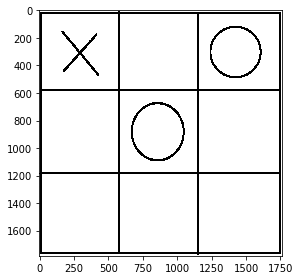

In [50]:
import numpy as np
import cv2
from skimage import io

#create a 2d array to hold the gamestate
gamestate = [["-","-","-"],["-","-","-"],["-","-","-"]]

width = 1764 
height = 1783
dim = (width, height)

#kernel used for noise removal
kernel =  np.ones((7,7),np.uint8)
# Load a color image 
img_o = cv2.resize(cv2.imread('./projekt/images/9.jpg'), dim, interpolation = cv2.INTER_AREA)
# get the image width and height
# img_width = img_o.shape[0]
# img_height = img_o.shape[1]


# turn into grayscale
img =  cv2.cvtColor(img_o, cv2.COLOR_BGR2GRAY)
# turn into thresholded binary
ret,thresh1 = cv2.threshold(img_g,127,255,cv2.THRESH_BINARY)
#remove noise from binary
img = cv2.morphologyEx(thresh1, cv2.MORPH_OPEN, kernel)
# img = cv2.dilate(img, kernel, iterations=2)
img = cv2.erode(img, kernel, iterations=1)
# img = cv2.Canny(img, 40, 300)

#find and draw contours. RETR_EXTERNAL retrieves only the extreme outer contours
contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(img_o, contours, -1, (0,255,0), 15)


io.imshow(img)
# tileCount = 0
# for cnt in contours:
#         # ignore small contours that are not tiles
#         if cv2.contourArea(cnt) > 200000: 
#                 tileCount = tileCount+1
#                 # use boundingrect to get coordinates of tile
#                 x,y,w,h = cv2.boundingRect(cnt)
#                 # create new image from binary, for further analysis. Trim off the edge that has a line
#                 tile = thresh1[x+40:x+w-80,y+40:y+h-80]
#                 # create new image from main image, so we can draw the contours easily
#                 imgTile = img[x+40:x+w-80,y+40:y+h-80]

#                 #determine the array indexes of the tile
#                 tileX = round((x/img_width)*3)
#                 tileY = round((y/img_height)*3)     

#                 # find contours in the tile image. RETR_TREE retrieves all of the contours and reconstructs a full hierarchy of nested contours.
#                 c, hierarchy = cv2.findContours(tile, cv2.RETR_TREE , cv2.CHAIN_APPROX_SIMPLE)
#                 for ct in c:
#                         # to prevent the tile finding itself as contour
#                         if cv2.contourArea(ct) < 210000:
#                                 cv2.drawContours(imgTile, [ct], -1, (255,0,0), 15)
#                                 #calculate the solitity
#                                 area = cv2.contourArea(ct)
#                                 hull = cv2.convexHull(ct)
#                                 hull_area = cv2.contourArea(hull)
#                                 solidity = float(area)/hull_area
                                
#                                 print(tileCount, solidity)

#                                 # fill the gamestate with the right sign
#                                 if(solidity > 0.5):
#                                         gamestate[tileX][tileY] = "O"
#                                         print('circle')
#                                 else: 
#                                         gamestate[tileX][tileY] = "X"
#                                         print('xxx')
#                 # put a number in the tile
#                 cv2.putText(img, str(tileCount), (x+200,y+300), cv2.FONT_HERSHEY_SIMPLEX, 10, (0,0,255), 20)

# #print the gamestate
# print("Gamestate:")
# for line in gamestate:
#         linetxt = ""
#         for cel in line:
#                 linetxt = linetxt + "|" + cel
#         print(linetxt)

# # resize final image
# res = cv2.resize(img,None,fx=0.2, fy=0.2, interpolation = cv2.INTER_CUBIC)

# io.imshow(res)